In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepshare-playground-series2/sample_submission.csv
/kaggle/input/deepshare-playground-series2/train_data.csv
/kaggle/input/deepshare-playground-series2/test_data.csv


In [2]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd
# 导入必要的Python库
# tqdm: 用于显示进度条，让长时间运行的代码看起来更友好
# matplotlib.pyplot: 用于数据可视化，创建各种图表
# seaborn: 基于matplotlib的高级可视化库，提供更美观的图表
# lightgbm: 微软开发的梯度提升框架，用于机器学习建模
# pandas: 数据处理和分析的核心库，用于处理表格数据

In [ ]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,log_loss
# 导入scikit-learn库中的关键模块
# StandardScaler: 标准化处理器，用于将特征缩放到均值为0，方差为1的标准正态分布
# KFold: K折交叉验证工具，用于模型验证和防止过拟合
# roc_auc_score: ROC曲线下面积指标，用于评估二分类模型的性能

In [5]:
train_df=pd.read_csv("/kaggle/input/deepshare-playground-series2/train_data.csv")
test_df=pd.read_csv("/kaggle/input/deepshare-playground-series2/test_data.csv")
# 从Kaggle数据集路径读取训练和测试数据
# train_df: 训练数据集，包含特征和标签，用于训练机器学习模型
# test_df: 测试数据集，通常只包含特征，用于模型预测
# 注意：需要先在Kaggle上下载数据集并放在指定路径下才能运行
# 数据集路径：/kaggle/input/deepshare-playground-series2/

In [7]:
train_df.head()

,label,user_id,item_id,item_fea1,user_fea1,user_fea2,user_fea3,user_fea4,lng,lat,user_fea5,ts,user_fea6,user_fea7,user_fea8,user_fea9,user_tag,ID
0,0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",0
1,0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",1
2,0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",2
3,0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",3
4,0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573311745524,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",4


In [8]:
df=pd.concat([train_df,test_df],axis=0).reset_index(drop=True)
# 合并训练集和测试集数据
# pd.concat(): pandas的合并函数，将多个数据框按行或列合并
# axis=0: 表示按行合并（垂直堆叠）
# reset_index(drop=True): 重新设置索引，删除原来的索引
# 这样做的目的通常是为了统一处理特征工程，保持一致性
df.head()

,label,user_id,item_id,item_fea1,user_fea1,user_fea2,user_fea3,user_fea4,lng,lat,user_fea5,ts,user_fea6,user_fea7,user_fea8,user_fea9,user_tag,ID
0,0.0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",0
1,0.0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",1
2,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",2
3,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",3
4,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573311745524,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",4


In [12]:
num_cols=[f'user_fea{i}' for i in range(6,9)]
cate_cols=['user_id','item_id']+[f'user_fea{i}' for i in range(1,6)]+['item_fea1']+['user_fea9']
# 定义数值特征和类别特征列名
# num_cols: 数值特征列，包含user_fea6, user_fea7, user_fea8
# 这些是连续的数值型特征，通常需要进行标准化处理
# cate_cols: 类别特征列，包含用户ID、物品ID和其他分类特征

In [14]:
df[num_cols]

,user_fea6,user_fea7,user_fea8
0,0.0,10.0,28.0
1,0.0,10.0,28.0
2,0.0,10.0,28.0
3,0.0,10.0,28.0
4,0.0,10.0,28.0
...,...,...,...
5811453,0.0,10.0,21.5
5811454,0.0,10.0,21.5
5811455,0.0,10.0,21.5
5811456,0.0,10.0,21.5


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

<Figure size 960x720 with 0 Axes>

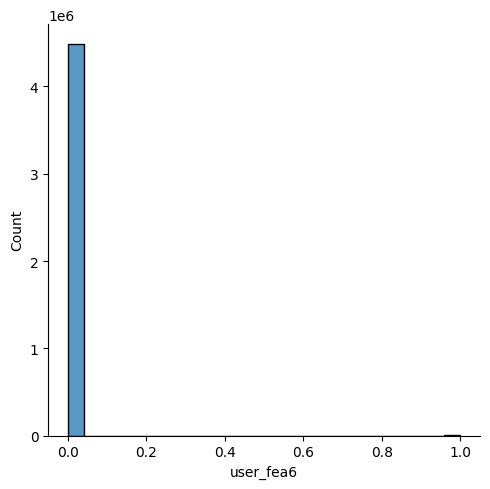

<Figure size 960x720 with 0 Axes>

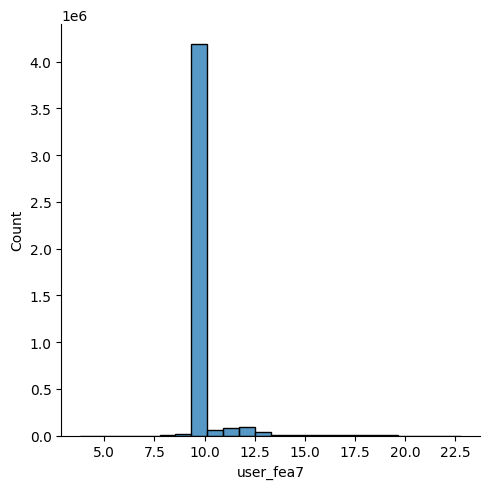

<Figure size 960x720 with 0 Axes>

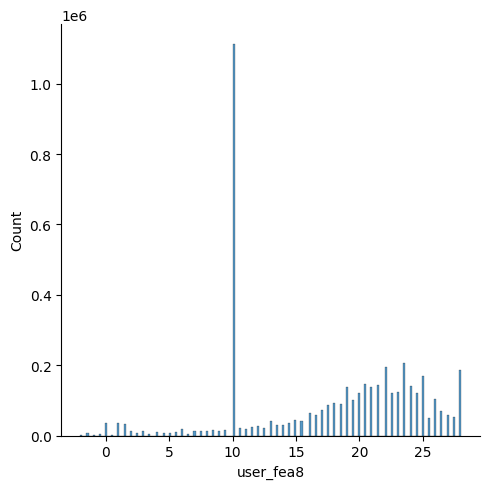

In [15]:
for col in tqdm(num_cols):
    plt.figure(dpi=150)
    sns.displot(df[col])
# 可视化数值特征的分布情况
# 这有助于了解数据的分布特征，发现异常值或偏态分布
# tqdm(num_cols): 为循环添加进度条，显示处理进度
# plt.figure(dpi=150): 设置图表分辨率为150dpi，提高图像清晰度
# sns.displot(): seaborn的分布图函数，显示数据的分布情况
# 这个循环会为每个数值特征生成一个分布图

In [18]:
# 正确的标准化流程：只在训练集上拟合，然后转换训练集和测试集
scaler=StandardScaler()
# 第一步：在训练集上拟合scaler（计算均值和标准差）
scaler.fit(train_df[num_cols])
# 第二步：用同一个scaler转换训练集
train_df[num_cols]=scaler.transform(train_df[num_cols])
# 第三步：用同一个scaler转换测试集
test_df[num_cols]=scaler.transform(test_df[num_cols])
# 重要原则：
# 1. 标准化参数（均值、标准差）只能从训练集学习
# 2. 测试集必须使用训练集学习到的参数进行转换
# 3. 这样可以避免数据泄露，确保模型评估的公正性
# 4. 绝不能在合并数据上fit，否则会造成信息泄露

In [ ]:
#离散变量编码
# 正确的类别特征编码流程：只在训练集上拟合，然后转换训练集和测试集
for col in tqdm(cate_cols):
    le=OneHotEncoder()
    # 第一步：在训练集上拟合LabelEncoder
    le.fit(df[col])
    # 第二步：用同一个LabelEncoder转换训练集
    df[col]=le.transform(df[col])


  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
df.head()

,label,user_id,item_id,item_fea1,user_fea1,user_fea2,user_fea3,user_fea4,lng,lat,user_fea5,ts,user_fea6,user_fea7,user_fea8,user_fea9,user_tag,ID
0,0.0,6593,259772,2,11,92,0,24,108.664005,22.244352,528,1573193245778,0.0,10.0,28.0,0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",0
1,0.0,6593,259772,2,11,92,0,24,108.664005,22.244352,528,1573193245778,0.0,10.0,28.0,0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",1
2,0.0,6593,490677,0,11,92,3,24,108.665033,22.246721,528,1573300837960,0.0,10.0,28.0,0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",2
3,0.0,6593,490677,0,11,92,3,24,108.665033,22.246721,528,1573300837960,0.0,10.0,28.0,0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",3
4,0.0,6593,490677,0,11,92,3,24,108.665033,22.246721,528,1573311745524,0.0,10.0,28.0,0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",4


In [27]:
train_df=df[df['label'].notna()].reset_index(drop=True)
test_df=df[df['label'].isna()].reset_index(drop=True)
# 根据标签列重新分割训练集和测试集
# df['label'].notna(): 选择标签不为空的行（训练数据）
# df['label'].isna(): 选择标签为空的行（测试数据）
# reset_index(drop=True): 重新设置索引，删除原来的索引
# 这种分割方式假设原始数据中训练集有标签，测试集没有标签

In [28]:
train_df.shape,test_df.shape
# 查看训练集和测试集的维度（形状）
# .shape 返回一个元组，表示数据的行数和列数
# 例如：(1000, 20) 表示1000行20列的数据
# 这有助于确认数据分割是否正确，以及数据规模

((3530252, 18), (2281206, 18))

In [29]:
drop_feature=['ID','label','day','item_desc','lng','lat','ts','user_tag']
features=[x for x in train_df.columns if x not in drop_feature]
print(len(features),features)
# 选择用于建模的特征
# drop_feature: 需要删除的列，这些列通常不是模型输入特征
# ID: 样本ID，没有预测价值
# label: 标签列，这是我们要预测的目标
# day, item_desc, lng, lat, ts, user_tag: 可能需要特殊处理或暂时不用的特征
# features: 最终用于训练模型的特征列表
# len(features): 特征的数量

12 ['user_id', 'item_id', 'item_fea1', 'user_fea1', 'user_fea2', 'user_fea3', 'user_fea4', 'user_fea5', 'user_fea6', 'user_fea7', 'user_fea8', 'user_fea9']


In [30]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_df[features],train_df['label'],test_size=0.2,random_state=2025)
# 划分训练集和验证集
# train_test_split: 将训练数据进一步分为训练集和验证集
# train_df[features]: 特征数据
# train_df['label']: 标签数据
# test_size=0.2: 验证集占20%，训练集占80%
# random_state=2025: 随机种子，确保每次划分结果一致
# 返回四个数组：训练特征、验证特征、训练标签、验证标签

In [31]:
model=lgb.LGBMClassifier()
model.fit(x_train,y_train)
y_val_pred=model.predict_proba(x_val)[:,1]

print(f'AUC:{roc_auc_score(y_val,y_val_pred)}')
print(f'logloss:{log_loss(y_val,y_val_pred)}')

y_pred=model.predict_proba(test_df[features])[:,1]
# 训练LightGBM模型并进行预测
# lgb.LGBMClassifier(): 创建LightGBM分类器
# model.fit(): 在训练数据上拟合模型
# predict_proba(): 预测概率，返回每个类别的概率
# [:,1]: 取第二列，即正类（类别1）的概率
# roc_auc_score: 计算AUC指标，评估模型性能
# log_loss: 计算对数损失，另一个评估指标

[LightGBM] [Info] Number of positive: 491822, number of negative: 2332379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 2824201, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174146 -> initscore=-1.556527
[LightGBM] [Info] Start training from score -1.556527
AUC:0.8262058151568515
logloss:0.36109713538748545


In [32]:
import sklearn


sklearn_sub_df=pd.DataFrame({
    'ID':test_df['ID'],
    'label':y_pred
})
sklearn_sub_df.to_csv('/kaggle/working/sklearn_baseline.csv',index=False)
# 创建提交文件
# pd.DataFrame(): 创建数据框，包含ID和预测结果
# 'ID': 测试样本的唯一标识符
# 'label': 模型预测的概率值
# to_csv(): 将结果保存为CSV文件
# '/kaggle/working/sklearn_baseline.csv': 保存路径，符合Kaggle格式
# index=False: 不保存行索引
# 这个文件可以直接提交到Kaggle竞赛平台